# <font color='grey'>packages for spatial analysis with:</font>

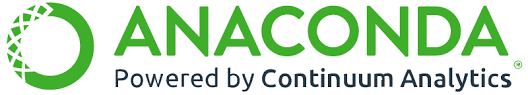

In [1]:
from IPython.display import Image,display
Image(filename='./images/anaconda.png')

* __large-scale data processing__
* __predictive analytics, and scientific computing__
* __simplify package management and deployment__
* __ installs into your home directory, i.e. no admin priveleges needed__ 

# [Download Anaconda](https://www.continuum.io/downloads)

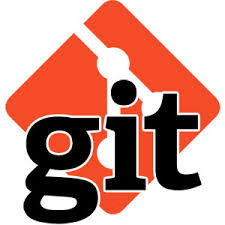

In [2]:
Image(filename='./images/git.jpg')

# [Download git](https://git-scm.com/downloads)

* __the most widely used modern version control system in the world today__
* __installs with vim on windows__
* __Code development and sharing__

# <font color='darkred'>Both of the above will need to be installed to go through the exercise, then..</font>

### **To create a virtual environment, start with the following command:**

#  C:\\> conda create -n envName jupyter geopandas folium

### **get the git repository [here](https://github.com/debboutr/SDMG) and either clone or fork it!**

### **github can be a text editor as well!**

# [LakeCat Dataset:](https://github.com/USEPA/LakeCat)<font color='green'> QA  Methods</font>

**The following code walk through the process of finding local lake basins with the on-network accumulation process. For each lake, we report the "catchment" statistics as a landscape summarization of the NHD Catchments associated by flowlines that hold the waterbodies COMID in the "WBAREACOMI" field. Using geopandas, we can do a unary_union with these catchments and compare the overlapping areas using the 'difference' method built in to geopandas. This script selects polys where we find less than 50% of the lake is covered by it's associated catchments and plots them with the folium package for a slippy map of each of the instances of poor coverage.**

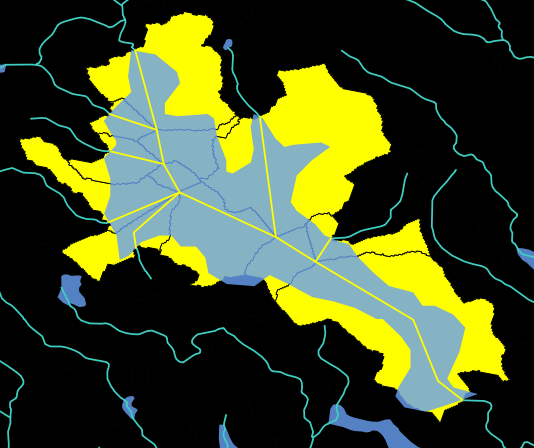

In [3]:
Image(filename='./images/linked.png')

_**LakeCat** sumarizes landscape metrics for **NHDWaterBody** watersheds. In order to report an accurate local basin for each, an array of **NHDCatchments** are accumlated in cases where more than one needed to cover the waterbody polygon_

_**NHDFlowlines** hold WBAREACOMI attribute that links flowlines to lakes.  We map those to catchments and come up with the local_ 'catchment' _basin, described in the 'Cat' statistics in LakeCat. This is a hybridized version of what the individual catchment is, the basin needs to cover the geometry of the water feature that it is describing_

## import geopandas, load and plot a shapefile, overlay with matplotlib

{'init': u'epsg:4269'}


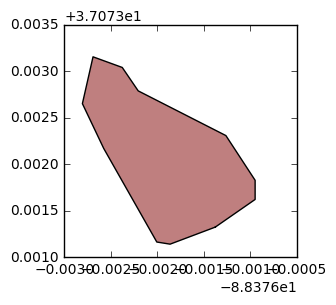

In [4]:
% matplotlib inline
import geopandas as gpd
lake = gpd.GeoDataFrame.from_file("./data/lake.shp")
print lake.crs  # GCS_North_American_1983
lake.plot(figsize=(3,3))

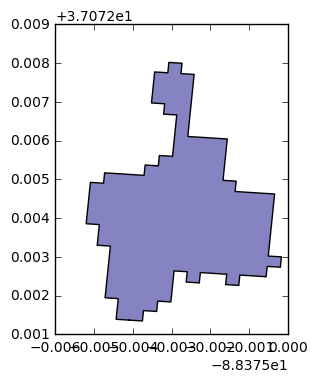

In [5]:
basin = gpd.GeoDataFrame.from_file("./data/basin.shp")
basin.plot(column='FEATUREID', cmap="plasma")

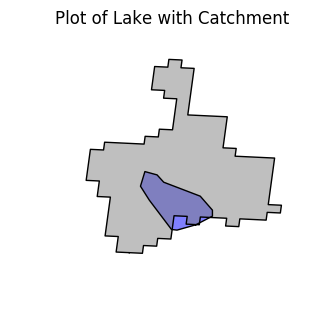

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(3,3))
base = lake.plot(ax=ax, color='blue')
basin.plot(ax=base, color='grey') 
ax.axis('off')
ax.set_title("Plot of Lake with Catchment")

### Access to attributes and statistics on fields

In [7]:
lakes = gpd.GeoDataFrame.from_file("./data/lakes.shp")
print 'AREASQKM : %s' % lakes.ix[lakes.COMID == 19742428].AREASQKM.values[0]  # find the attribute value of a single record
print 'Max: %s' % lakes.AREASQKM.max()
print 'Min: %s' %lakes.AREASQKM.min()
print 'Mean: %s' %lakes.AREASQKM.mean()
print 'Standard Deviation: %s' %lakes.AREASQKM.std()
lakes.head()

AREASQKM : 0.153
Max: 258.586
Min: 0.003
Mean: 2.95254965358
Standard Deviation: 19.1071153653


,AREASQKM,COMID,ELEVATION,FCODE,FDATE,FTYPE,GNIS_ID,GNIS_NAME,REACHCODE,RESOLUTION,SHAPE_AREA,SHAPE_LENG,VPU,geometry
0,0.056,22538778,0.0,43606,1999-06-17,Reservoir,None,None,None,Medium,0.000006,0.011360,06,POLYGON ((-82.20423298284258 36.96521067595594...
1,0.153,19742428,0.0,39004,1999-09-13,LakePond,992811,Price Lake,06010103001192,Medium,0.000015,0.021951,06,POLYGON ((-81.73179191690925 36.13824407723956...
2,0.014,19742448,0.0,39004,1999-09-13,LakePond,1017337,Inver Lochy Lake,06010103001195,Medium,0.000001,0.004810,06,POLYGON ((-81.83639331674688 36.12086041059987...
3,0.049,14638207,0.0,39004,1999-09-13,LakePond,None,None,06010205001811,Medium,0.000005,0.011417,06,"POLYGON ((-81.94507331657819 36.9739958759423,..."
4,0.010,14638213,0.0,39004,1999-09-13,LakePond,None,None,06010205001814,Medium,0.000001,0.004532,06,POLYGON ((-81.95456138323013 36.96109927596232...


### Similar approach using arcpy -- often leads to creating intermediate data or looping with a cursor
```
import arcpy
home = r"C:\Users\Rdebbout\Downloads\SpatialData"
shp = arcpy.MakeFeatureLayer_management("{}/NHDPlus16/NHDWaterbodies.shp".format(home))
fldList = arcpy.ListFields(shp)
for fld in fldList:
    print fld.name
rows = arcpy.SearchCursor(shp)
row = rows.next()
totalSize = 0
recordsCounted = 0 
while row:
    totalSize += row.getValue('AREASQKM')
    recordsCounted += 1
    row = rows.next()
average = totalSize / recordsCounted

arcpy.Statistics_analysis("NHDWaterbodies_Layer", "./outTable.dbf", [["AREASQKM","MEAN"]])
```

### FInd the difference of the 2 geometries using geopandas and shapely methods

0    1.961543e-07
dtype: float64


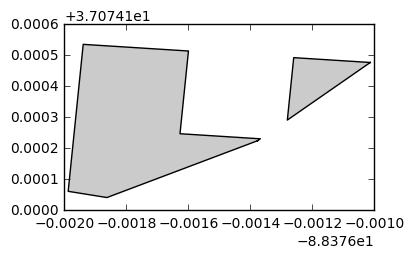

In [10]:
print lake['geometry'].difference(basin.unary_union.buffer(0)).area
lake['geometry'].difference(basin.unary_union.buffer(0)).plot(figsize=(4,4))     

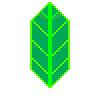

In [4]:
Image(filename='./images/folium.jpg')

## <font color='orange'>The code below creates a leaflet map using folium</font>

In [8]:
import sys
import pandas as pd
sys.path.append('D:/Projects/StreamCat')
from StreamCat_functions import findUpstreamNpy, makeVPUdict
NHD_dir = 'D:/NHDPlusV21'
inputs = makeVPUdict(NHD_dir)
lks = gpd.GeoDataFrame()
bsn = gpd.GeoDataFrame()
miss = gpd.GeoDataFrame()
lksnet = gpd.GeoDataFrame.from_file('D:/Projects/lakesAnalysis/new/NetworkLakes.shp')
catnumps = 'D:/Projects/lakesAnalysis/On_Net_Npy_files/children'
for zone in inputs:
    hr = inputs[zone]
    lakes = lksnet.ix[lksnet.VPU == zone]  
    cats = gpd.GeoDataFrame.from_file('%s/NHDPlus%s/NHDPlus%s/NHDPlusCatchment/Catchment.shp' % (NHD_dir,hr, zone))   
    lookup = pd.read_csv('D:/Projects/lakesAnalysis/On_Network_LakeCOMs/LakeCOMs%s.csv' % zone)
    for idx, row in lookup.iterrows():
        lake = lakes.ix[lakes.COMID == row.wbCOMID]
        catbas = findUpstreamNpy(zone, int(row.catCOMID), catnumps)
        basin = cats.ix[cats.FEATUREID.isin(catbas)]
        try: 
            diffgeom = lake['geometry'].difference(basin.unary_union.buffer(0))
            pct = diffgeom.area / lake.area * 100
            if pct.values[0] > 50:
                lks = pd.concat([lks, lake])
                bsn = pd.concat([bsn, basin])
                miss = pd.concat([miss, gpd.GeoDataFrame(data={'PCT': pct},geometry=diffgeom)])
        except:
            print row.wbCOMID
            continue

TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -83.55969418159917 36.3934340772607 at -83.55969418159917 36.3934340772607


166997561.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -87.994943579174645 35.55474577981515 at -87.994943579174645 35.55474577981515


166997626.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -87.000008908731957 34.655031279541845 0 at -87.000008908731957 34.655031279541845 0
Ring Self-intersection at or near point -87.000008908731957 34.655031279541845 0


167679168.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -78.901113106478107 42.044401875176824 at -78.901113106478107 42.044401875176824


166899002.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -87.801996707487049 36.500066276677906 0 at -87.801996707487049 36.500066276677906 0
Ring Self-intersection at or near point -87.801996707487049 36.500066276677906 0


166899385.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -100.39077073406148 45.637766897131328 at -100.39077073406148 45.637766897131328


19251179.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -106.54486286717204 47.962023152628809 at -106.54486286717204 47.962023152628809


167204901.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -110.20390270079844 44.317719183373754 at -110.20390270079844 44.317719183373754


167204959.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -97.565794871213669 42.163466175979259 at -97.565794871213669 42.163466175979259


17272914.0


TopologyException: found non-noded intersection between LINESTRING (-92.7611 38.1681, -92.7611 38.168) and LINESTRING (-92.7611 38.1682, -92.7611 38.168) at -92.761129365213634 38.16801109237479 0


167267897.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -93.599349445549052 44.893190940458297 at -93.599349445549052 44.893190940458297


1101734.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -96.243419005938449 44.307855983194045 at -96.243419005938449 44.307855983194045


4136984.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -94.053411715512482 46.774396591400695 at -94.053411715512482 46.774396591400695


4619930.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -94.119706673658442 46.700544427372812 at -94.119706673658442 46.700544427372812


4620258.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -88.610291481318157 42.612015972435607 at -88.610291481318157 42.612015972435607


13294928.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -89.431868882959918 45.913080814707222 at -89.431868882959918 45.913080814707222


13393637.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -89.522981124537125 45.840277540727634 at -89.522981124537125 45.840277540727634


13393923.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -89.284068821062448 45.636671683391718 at -89.284068821062448 45.636671683391718


13395039.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -89.472735087071158 39.203630472813536 at -89.472735087071158 39.203630472813536


13880948.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -89.721947831187606 44.742692908642169 at -89.721947831187606 44.742692908642169


14731996.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -91.070592349322581 41.172235701778462 at -91.070592349322581 41.172235701778462


14806577.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -94.715594531744642 47.575712351720171 at -94.715594531744642 47.575712351720171


22322013.0


TopologyException: found non-noded intersection between LINESTRING (-91.6899 39.4545, -91.6897 39.4547) and LINESTRING (-91.6897 39.4545, -91.6897 39.4547) at -91.689693139948901 39.454705003754547 0


937110111.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -95.261288647779253 35.632657404399261 at -95.261288647779253 35.632657404399261


381408.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -95.475477083392533 34.130145484826599 at -95.475477083392533 34.130145484826599


592596.0


TopologyException: found non-noded intersection between LINESTRING (-93.1996 36.6754, -93.1994 36.6757) and LINESTRING (-93.1994 36.6754, -93.1994 36.6757) at -93.199428047253718 36.675664729392345 0


7623838.0


TopologyException: found non-noded intersection between LINESTRING (-96.4624 36.1326, -96.4621 36.1331) and LINESTRING (-96.4624 36.1326, -96.4624 36.1329) at -96.462365792799545 36.132645671179866 0


20971700.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -92.207829803167883 36.26521664553028 at -92.207829803167883 36.26521664553028


120052259.0


TopologyException: found non-noded intersection between LINESTRING (-92.2221 35.6438, -92.2217 35.6441) and LINESTRING (-92.2217 35.6439, -92.2217 35.6441) at -92.221708074206859 35.644083517649868 0


167299819.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -95.016120603090741 35.441391408103932 at -95.016120603090741 35.441391408103932


167801029.0


TopologyException: EdgeRing::computePoints: found null Directed Edge


941070128.0


TopologyException: found non-noded intersection between LINESTRING (-110.858 37.3475, -110.859 37.3478) and LINESTRING (-110.859 37.3478, -110.859 37.3477) at -110.85919695734266 37.347799563138636 0


3528295.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -69.505568465488565 45.864980553409893 at -69.505568465488565 45.864980553409893


1700982.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -68.213675287395048 44.934117332777959 at -68.213675287395048 44.934117332777959


2678834.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -69.46525703543935 44.424914744991369 at -69.46525703543935 44.424914744991369


5201928.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -72.89986242285147 42.821556032879236 at -72.89986242285147 42.821556032879236


10294116.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -69.37192203692878 46.060284293066182 at -69.37192203692878 46.060284293066182
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -68.9950962781448 45.669013201383422 at -68.9950962781448 45.669013201383422


120053064.0
120053074.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -115.29754750037107 48.494238237055328 at -115.29754750037107 48.494238237055328


22886855.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -113.89630804569528 48.294582836107509 at -113.89630804569528 48.294582836107509


22971534.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -118.07544650636063 47.240948484611607 at -118.07544650636063 47.240948484611607


23466505.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -112.14484920303542 43.385591732656884 0 at -112.14484920303542 43.385591732656884 0
Ring Self-intersection at or near point -112.14484920303542 43.385591732656884 0


24566837.0


TopologyException: found non-noded intersection between LINESTRING (-116.943 44.784, -116.943 44.7842) and LINESTRING (-116.943 44.7843, -116.943 44.7842) at -116.94288496198675 44.784166977543826 0


120054057.0


TopologyException: found non-noded intersection between LINESTRING (-113.947 36.1314, -113.952 36.1318) and LINESTRING (-113.952 36.1318, -113.952 36.1318) at -113.95188457899326 36.131840383019949 0


22071698.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -95.138511544323208 32.237948308934129 at -95.138511544323208 32.237948308934129


1147787.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -93.866618855721768 29.963424906256975 at -93.866618855721768 29.963424906256975


1477365.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -95.372336572117405 30.859440075252632 at -95.372336572117405 30.859440075252632


1492358.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -94.788489356641136 29.823652945335667 at -94.788489356641136 29.823652945335667


1514163.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -97.205037999498799 28.695173907683781 at -97.205037999498799 28.695173907683781


1637751.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -96.541274332671719 30.307201759077532 at -96.541274332671719 30.307201759077532


5569731.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -100.29581347664184 32.066787365363673 at -100.29581347664184 32.066787365363673


5721267.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -98.375762683375982 28.520716493900942 at -98.375762683375982 28.520716493900942


120052363.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -94.017333296640501 29.72606408018839 at -94.017333296640501 29.72606408018839


120052636.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -99.022552479598289 32.751780431818645 at -99.022552479598289 32.751780431818645


120053367.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -90.794610471532096 48.173779889590271 at -90.794610471532096 48.173779889590271
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -91.938392882325303 48.213957295006949 at -91.938392882325303 48.213957295006949


7094079.0
7095015.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -91.460240796842371 48.094846624827973 at -91.460240796842371 48.094846624827973


7097779.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -92.199120405249275 48.348588210034833 at -92.199120405249275 48.348588210034833


7100709.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -90.947065011023511 48.251641974565075 at -90.947065011023511 48.251641974565075


120052201.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -101.68001576275232 48.681540976531608 at -101.68001576275232 48.681540976531608


120052509.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -75.14769031309919 39.26931029622466 at -75.14769031309919 39.26931029622466


9484044.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -90.091983842201998 35.081635636103996 at -90.091983842201998 35.081635636103996


7473288.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -90.888777299666685 29.233477639251369 at -90.888777299666685 29.233477639251369


11079171.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -93.511601531257597 34.638773743739556 at -93.511601531257597 34.638773743739556


15231972.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -89.744196099843762 29.775453582328083 at -89.744196099843762 29.775453582328083


22766516.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -91.958530182488573 31.091502764370262 at -91.958530182488573 31.091502764370262


167182370.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -90.036654574945118 29.528635603413136 at -90.036654574945118 29.528635603413136


167806606.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -90.8645468753936 47.913418791950654 at -90.8645468753936 47.913418791950654


4796084.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -84.240487135703788 42.202756590998966 at -84.240487135703788 42.202756590998966


12244454.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -74.78787994108211 44.079377599152636 at -74.78787994108211 44.079377599152636


15466235.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -82.635402160263766 42.561430142200535 at -82.635402160263766 42.561430142200535


120053703.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -84.221869206042655 30.627182696607765 at -84.221869206042655 30.627182696607765


10361818.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -85.462868977784524 34.193472813591562 0 at -85.462868977784524 34.193472813591562 0
Ring Self-intersection at or near point -85.462868977784524 34.193472813591562 0


15822839.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -87.739280103799572 32.967432858840617 at -87.739280103799572 32.967432858840617


21677972.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -87.901518907332616 31.008497418535285 0 at -87.901518907332616 31.008497418535285 0
Ring Self-intersection at or near point -87.901518907332616 31.008497418535285 0


120052703.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -86.310529910696545 32.438846796594277 at -86.310529910696545 32.438846796594277


120052975.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -86.230009871502659 33.553966544310718 at -86.230009871502659 33.553966544310718


166759059.0


TopologyException: Input geom 1 is invalid: Ring Self-intersection at or near point -79.853532794803158 34.778281654674302 at -79.853532794803158 34.778281654674302


9164658.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -80.797433648367004 34.398679813535061 at -80.797433648367004 34.398679813535061


9737130.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -80.092313591783721 35.466537144890744 at -80.092313591783721 35.466537144890744


166737840.0


TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -121.9581803878032 42.464302267420301 0 at -121.9581803878032 42.464302267420301 0
Ring Self-intersection at or near point -121.9581803878032 42.464302267420301 0


120054054.0


In [ ]:
lks.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\lks.json",driver="GeoJSON")
bsn.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\bsn.json",driver="GeoJSON")
miss.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\miss.json",driver="GeoJSON")

In [ ]:
def color(vpu):
    if vpu in ['01']:
        col='red'
    elif vpu in ['02']:
        col='pink'
    elif vpu in ['03W']:
        col='darkpurple'
    elif vpu in ['03S']:
        col='beige'
    elif vpu in ['03N']:
        col='cadetblue'
    elif vpu in ['04']:
        col='darkgreen'
    elif vpu in ['05']:
        col='purple'
    elif vpu in ['06']:
        col='lightred'        
    elif vpu in ['07']:
        col='lightgreen'
    elif vpu in ['08']:
        col='gray'
    elif vpu in ['09']:
        col='darkblue'        
    elif vpu in ['10U']:
        col='lightgray'
    elif vpu in ['10L']:
        col='lightblue'
    elif vpu in ['11']:
        col='black'
    elif vpu in ['12']:
        col='darkblue'
    elif vpu in ['13']:
        col='beige'        
    elif vpu in ['14']:
        col='darkred'
    elif vpu in ['15']:
        col='orange'
    elif vpu in ['16']:
        col='purple'        
    elif vpu in ['17']:
        col='green'
    elif vpu in ['18']:
        col='blue'
    return col

In [ ]:
import folium
f_map=folium.f_map(location=[lat_Center, lon_Center],zoom_start=4,tiles="Stamen Terrain")
fg=folium.FeatureGroup(name="Lake Points")
for lat,lon,name,vpu in zip(lks['geometry'].centroid.f_map(lambda p: p.y),lks['geometry'].centroid.f_map(lambda p: p.x),lks['COMID'], lks['VPU']):
        fg.add_child(folium.Marker(location=[lat,lon],popup=("NHD Waterbody <b>COMID</b>: %s" % name),
                                   icon=folium.Icon(icon_color='white',color=color(vpu), icon='cloud')))
f_map.add_child(fg)
f_map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\lks.json'),
                name='NHD Lake',
                style_function=lambda x: {'fillColor':'blue', 'fill_opacity': 0.4, 'color':'none'}))
f_map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\bsn.json'),
                name='Catchment Basin',
                style_function=lambda x: {'fillColor':'grey', 
                          'fill_opacity': 0.3,
                          'color':'white'}))
f_map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\miss.json'),
                name='Missed Area',
                style_function=lambda x: {'fillColor':'red', 'fill_opacity': 0.2, 'color':'none'}))
f_map.add_child(folium.LayerControl())
f_map.save(outfile=r'C:\Users\Rdebbout\Plot2Shps\tot_1.html')
